## Final Project Submission

Please fill out:
* Student name: Steven Rosa
* Student pace: part time
* Scheduled project review date/time: Tues 27 Nov 2018 5pm
* Instructor name: Jeff Herman
* Blog post URL:


# King County Housing Data Analysis

Using data describing conditions, sizes, locations, &c., of houses in King County, can we build a model to optimize the price of a house?

In [2]:
import pandas as pd             #for working with data as a DataFrame object
import matplotlib.pyplot as plt #for plotting simple visualizations
import numpy as np              #for math operations like log
import seaborn as sns           #for plotting advanced visualizations
import random                   #for generating random numbers for train/test split
import copy                     #for making deep copies of mutable objects

#for dividing data into a training set and a testing set
from sklearn.model_selection import train_test_split 

#for fitting the model to training and testing data
from sklearn.linear_model import LinearRegression

#for calculating MSE of residuals
#(squares each error to remove cancelling-out effect of negative errors, 
#then finds mean of them all)
from sklearn.metrics import mean_squared_error

#for selecting the most important features in a model
from sklearn.feature_selection import RFE

#for running regression models with Ordinary Least Squares
import statsmodels.formula.api as smf

In [4]:
#To read house prices as $ amounts instead of in scientific notation
pd.set_option('display.float_format', '{:.2f}'.format) 

In [5]:
#Function to draw in-line histograms
def inlinehists(xs, data, bins):
    fig, axs = plt.subplots(1, len(xs), sharey=False, figsize=((5 * len(xs), 4)))
    for i, x in enumerate(xs):
        data[x].hist(ax=axs[i], label=x, xlabelsize=5, bins=bins)
        axs[i].legend()
    plt.show()

In [6]:
#Function to draw a heat map to show collinearity among features.
#Uses seaborn's "corr" object and "mask" and "cmap"
def draw_heat_map(df, title):
    sns.set(style="white")
    corr = df.corr() # Create a covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool) #a mask the size of the matrix
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(10, 8)) # Set up the matplotlib figure
    ax.set_title(title, fontdict={'fontsize': 'large'})
    cmap = sns.diverging_palette(220, 10, as_cmap=True) #custom diverging colormap
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, #Draw the heatmap
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [7]:
#Function to calcluate and predict Mean Squared Errors for training and testing 
#data using sklearn's Linear Regression object and mean_squared_error function.
def calc_MSEs(data, target, test_size):
    features = data.drop([target], axis=1)
    target = data[target]
    X = features
    y = target

    #Divide the data in X and y into proportionate sets for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(test_size))

    linreg = LinearRegression() #Initialize a model
    linreg.fit(X_train, y_train) #Fit the training data to the model

    #Calculate predicted y (target) values on the training set of x (features)
    y_hat_train = linreg.predict(X_train)
    #Calculate predicted y (target) values on the testing set of x (features)
    y_hat_test = linreg.predict(X_test)

    #Crunch the MSE for training data and testing data
    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)
    
    print('MSE for training data:', train_mse)
    print('MSE for testing data:', test_mse)
    print('Intercept:', linreg.intercept_)
    print('R-squared score:', linreg.score(X, y))

In [8]:
#Function to use scikitlearn's RFE to select features.
#Returns 3 measures to be captured by new variables
def select_features(df, target_col, num_of_feats):
    features = df.drop([target_col], axis=1)
    target = df[target_col]
    X = features
    y = target
    linreg = LinearRegression() #Instantiate a new linreg object
    #Instantiate a selector object to choose features
    selector = RFE(linreg, n_features_to_select = num_of_feats) 
    selector = selector.fit(X, y)
    selector.support_ #Returns an array of bools with selected features "True"
    #Take only those columns from X that were chosen by the selector
    selected_columns = X.columns[selector.support_ ]
    #Fit the selected columns to another model
    linreg.fit(X[selected_columns],y)
    intercept = linreg.intercept_
    r_squared = linreg.score(X[selected_columns], y)
    
    return selector.support_, intercept, r_squared

In [9]:
#Function to write the 'formula' for statsmodel's Ordinary least Squares function
#and to call that function on provided data.
#Returns the model
def build_ols_model(x, y, data, target):

    columns = "+".join(x)
    formula = target + ' ~'+ columns
    model = smf.ols(formula = formula, data = data).fit()
    return model

In [10]:
#Function to print the relevant stats from a statsmodel Ordinary Least Sqaures model
def print_ols_stats(model):
    print('R-squared:', model.rsquared)
    print('R-squared adjusted:', model.rsquared_adj)
    print('Intercept:', model.params[0])
    print('Slope:', model.params[1])

In [56]:
#Function to calculate R-squared scores while iteratively selecting
# features to add to the model.
#Returns a pandas DataFrame with the R-squared values in ascending order,
#the features added, and the frequency of selection of each feature.
def r_squared_as_features_increase(data, target):
    features = data.drop([target], axis=1)
    num_of_cols = len(features.columns)
    #keep track of how many times each column is chosen
    selected_columns = np.zeros(shape = num_of_cols) 
    intercepts = []
    r_squareds = []
    #iterate over the full range of features in the df
    for i in range(1, (num_of_cols + 1)):
        #Call the select features function which uses sklearn's linear Regression object
        selected, intercept, r_squared = select_features(data, target, i) 
        selected_columns += selected.astype('int') # add these to the total
        intercepts.append(intercept) #add intercept to the total
        r_squareds.append(r_squared) #add r_squared to the total

    # Zip features together with their counts from feature selection
    column_totals_unsorted = zip(features.columns, selected_columns) 
    #Put features in order by their number of times used in feature selection
    column_totals = sorted(column_totals_unsorted, key=lambda tup: tup[1], reverse=False)

    #Build a new df to bring together features selected, their frequency of selection,
    #and the r-squared score of the model when each new feature is added
    column_totals_df = pd.DataFrame(column_totals)
    column_totals_df = column_totals_df.rename(index=str, columns={0: 'feature', 1: 'count'})
    r_squareds_df = pd.DataFrame(r_squareds)
    r_squareds_df = r_squareds_df.rename(index=str, columns={0: 'r-squared'})
    #A new df listing r_squareds, features selected in order, and their counts
    df_iter_rsqds = pd.concat([column_totals_df, r_squareds_df], axis=1)

    return df_iter_rsqds

In [12]:
#Function to draw a line graph showing the relationship between number of 
#features selected in the increase in R-squared score as each feature is 
#added to the model.
#Takes in the DataFrame returned by the r_squared_as_features_increase function.
def plot_iter_rsqds(data):
    x = pd.DataFrame(data['count'])
    y = pd.DataFrame(data['r-squared'])
    fig = plt.figure(figsize = (7,5))
    plt.plot(x, y)
    plt.title('R-squared as number of selected features increases')
    plt.show()

In [69]:
#Function to generate r-squared scores for data over a range of train/test splits.
#Draws a plot to show range of errors across range of splits
def plot_tt_splits(features, target):

    random.seed(9) #to distribute data into train/test sets randomly
    X = features
    y = target
    training_scores = [] #list of mean training errors, to be plotted
    testing_scores = [] #list of mean testing errors, to be plotted
    sizes = list(range(5,80,5))
    linreg = LinearRegression() #Initialize a model
    
    for size in sizes:
        training_score_iter = [] #from which to take mean of training errors
        testing_score_iter = [] #from which to take mean of testing errors
        
        #generate errors 50 times, then take the mean to be plotted
        for i in range(50):
            
            #split the data proportionally using a "size" from "sizes"
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(size/100))
            #fit the training data to a model
            linreg.fit(X_train, y_train)
            #generate predicted y values (a line) from the training x variables
            y_hat_train = linreg.predict(X_train)
            #generate predicted y values (a line) from the testing x variables
            y_hat_test = linreg.predict(X_test)
            #add r-squared score for training data to list from which to take mean
            training_score_iter.append(linreg.score(X_train, y_train))
            #testing_score_iter.append(mean_squared_error(y_test, y_hat_test))
            testing_score_iter.append(linreg.score(X_test, y_test))
            #(exit for loop)
        
        #add the mean of the training errors to the list to be plotted
        training_scores.append(np.mean(training_score_iter)) 
        #add the mean of the testing errors to the list to be plotted
        testing_scores.append(np.mean(testing_score_iter))
        #(exit for loop)
    
    plt.scatter(sizes, training_scores, label='Mean training scores')
    plt.scatter(sizes, testing_scores, label='Mean testing scores')
    plt.title('Comparison of mean test/train scores after 5/95 to 80/20 split')
    plt.legend()

# Obtaining the raw data

In [ ]:
#Import data as a Pandas DataFrame
df_raw = pd.read_csv('kc_house_data.csv') 

## A first look at the raw data

In [9]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [10]:
df_raw.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,19221.00,21534.00,21597.00,21597.00,21597.00,21597.00,17755.00,21597.00,21597.00,21597.00,21597.00,21597.00
mean,4580474287.77,540296.57,3.37,2.12,2080.32,15099.41,1.49,0.01,0.23,3.41,7.66,1788.60,1971.00,83.64,98077.95,47.56,-122.21,1986.62,12758.28
std,2876735715.75,367368.14,0.93,0.77,918.11,41412.64,0.54,0.09,0.77,0.65,1.17,827.76,29.38,399.95,53.51,0.14,0.14,685.23,27274.44
min,1000102.00,78000.00,1.00,0.50,370.00,520.00,1.00,0.00,0.00,1.00,3.00,370.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00
25%,2123049175.00,322000.00,3.00,1.75,1430.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00
50%,3904930410.00,450000.00,3.00,2.25,1910.00,7618.00,1.50,0.00,0.00,3.00,7.00,1560.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00
75%,7308900490.00,645000.00,4.00,2.50,2550.00,10685.00,2.00,0.00,0.00,4.00,8.00,2210.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00
max,9900000190.00,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00


**Observations of data summary**

Columns to drop: ID and date (not useful here); lat and long (would be useful, but they're outside the scope of this exploration.)

Categorical columns to transform later: waterfront, view, condition, grade, zip code.

Null values to fill: waterfront, view, yr_renovated.

Price column initially displayed in scientific notation. Suppressed this globally so that prices can be understood as $ amounts.

The max value for bedrooms is preposterous and that row will probably need to be dropped if the rest of the data in the row doesn't describe a 33-bedroom house. Dropping it might also improve the distribution of other columns.

sqft_basement should be in integers to match sqft_above.

**Observations of histograms of each feature**



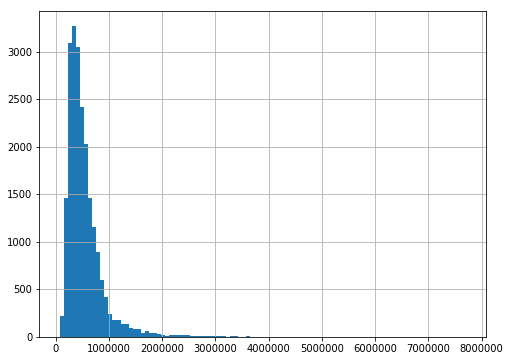

In [11]:
df_raw['price'].hist(bins=100, figsize=(8,6))

**price**: Will serve as the target, i.e. 'y', the dependent variable. We'll examine how other features effect the price of a house. A few extreme outliers on the positive side are skewing the data. (Extravagant mansions worth over 3 or 4 million dollars.) Might help to drop them.

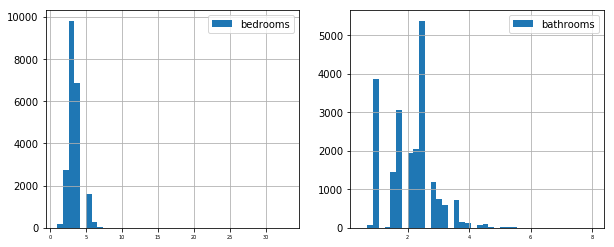

In [12]:
inlinehists(['bedrooms', 'bathrooms'], df_raw, 40)

**bedrooms**: Positively-skewed by a few many-bedroomed houses.

**bathrooms**: Looks not too far from a normal distribution, can probably be smoothed out. Some positive skew.

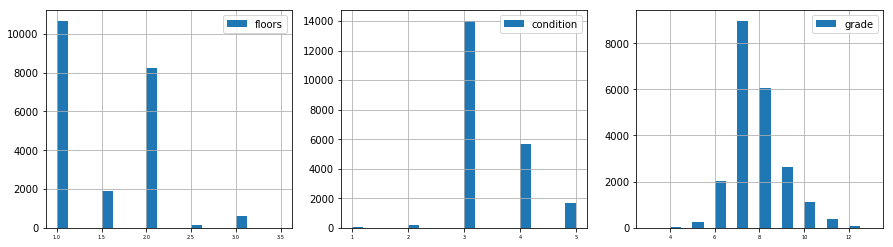

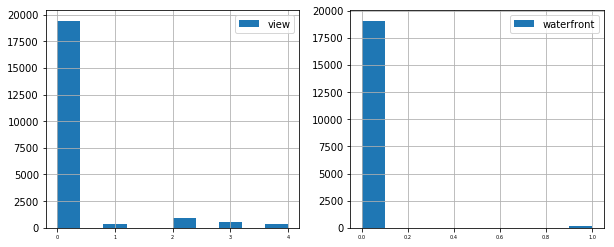

In [13]:
inlinehists(['floors', 'condition', 'grade'], df_raw, 20)
inlinehists(['view', 'waterfront'], df_raw, 10)

**floors**: Looks categorical but would remain useful as a numerical feature for its mean, &c. Densely-distributed around the 1-floor and 2-floor values. This makes sense as a house with with fewer than 1 floor wouldn't fit humans.

**condition**: Categorical; not too abnormally-distributed. Makes sense that most houses would be in a medium condition.

**grade**: Categorical; very normally-distributed. Similar to condition, most houses have a "medium" grade which makes sense. The tails of the distribution will be rundown houses and fancy houses.

**view**: A categorical feature with most houses having a "0" view. Makes sense intuitively that the this data wouldn't be normally distributed: the majority of houses wouldn't have even a "medium"-grade view. They'd have no interesting view at all, just a view of other houses in their neighborhood.

**waterfront**: A categorical feature, "yes" or "no", with the vast majority of houses not being on the waterfront. Makes sense. Might be the case that dropping the extravagant mansion rows will remove most of the "yes" waterfront houses, meaning this column will need to be dropped.

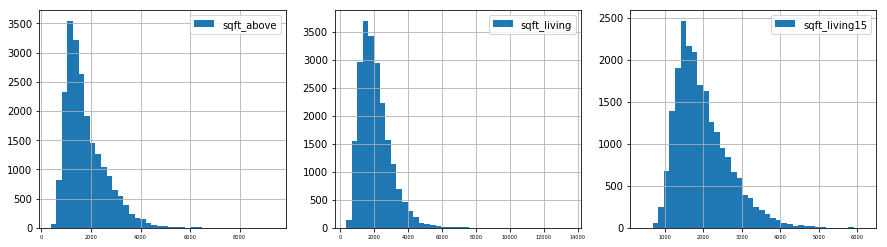

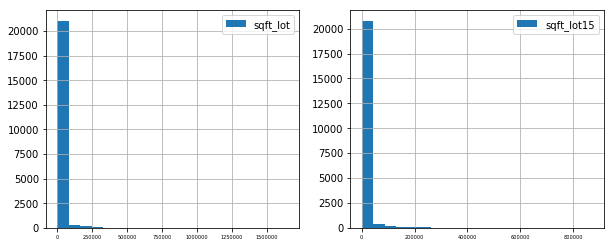

In [14]:
inlinehists(['sqft_above', 'sqft_living', 'sqft_living15'], df_raw, 40)
inlinehists(['sqft_lot', 'sqft_lot15'], df_raw, 20)

**sqft_above**: Close to a normal distribution wiht some outliers positively skewing the data.

**sqft_living**: Similar shape to sqft_above, outliers positively skewing the data.

**sqft_living15**: Even more normal than sqft_living. Probably contains fewer meaningful values.

**sqft_lot**: A few extreme outliers are positively skewing the data. Might be the same extravagant mansions.

**sqft_lot15**: Similar issue to sqft_lot. A few extreme outliers are positively skewing the data.

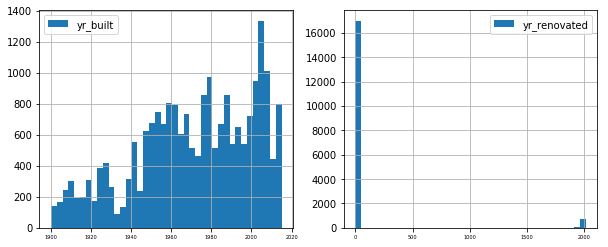

In [15]:
inlinehists(['yr_built', 'yr_renovated'], df_raw, 40)

**yr_built**: Negative skew towards earlier years. A spurt of new construction in the very recent past. Not sure whether to expect a normal distribution of this feature if we assume that the population of the city increases steadily from decade to decade; the bulk of the housing stock would already exist and wouldn't be replaced, but some new residents would move into new construction neighborhoods.

**yr_renovated**: If only describing renovations after 2015, then it's a categorical column.

# Scrubbing the raw data

In [14]:
#Prevents dropped rows from throwing errors later
df_raw = df_raw.reset_index(drop=True)

In [15]:
#Drop the id and date columns
df_raw = df_raw.drop(['id', 'date', 'lat', 'long'], axis=1) 

## Scrubbing: dropping the 33-bedroom house

Let's check if there are any other over-bedroomed houses.

In [16]:
df_raw['bedrooms'].value_counts() #Check for other houses with a lot of bedrooms

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

The 10- and 11-bedroom houses also look suspicious.

In [19]:
beds_10 = df_raw[df_raw['bedrooms'] >= 10]  
beds_10

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
8748,520000.00,11,3.00,3000,4960,2.00,0.00,0.00,3,7,2400,600.0,1918,1999.00,98106,1420,4960
13301,1150000.00,10,5.25,4590,10920,1.00,0.00,2.00,3,9,2500,2090.0,2008,0.00,98004,2730,10400
15147,650000.00,10,2.00,3610,11914,2.00,0.00,0.00,4,7,3010,600.0,1958,0.00,98006,2040,11914
15856,640000.00,33,1.75,1620,6000,1.00,0.00,0.00,5,7,1040,580.0,1947,0.00,98103,1330,4700
19239,660000.00,10,3.00,2920,3745,2.00,0.00,0.00,4,7,1860,1060.0,1913,0.00,98105,1810,3745


The only house whose specs look plausible is row 13301. (5 bathrooms, price over 1 mil.) Going to drop the others.

In [17]:
df_raw = df_raw.drop([8748, 15147, 15856, 19239]) # Drop the rows with 10-or-more-bed houses

In [18]:
df_raw = df_raw.reset_index(drop=True) #Prevents dropped rows from throwing errors later

## Scrubbing: dropping the extravagant mansions

Positive skew in the histogram of the price column suggests that a few extremely-high-value houses could be dropped.

In [22]:
print('99% of houses have a price under', df_raw['price'].quantile(.99)) #Return 99th percentile

99% of houses have a price under 1970000.0


In [23]:
over2mil = df_raw[df_raw['price'] > 2000000]
over3mil = df_raw[df_raw['price'] > 3000000]
over4mil = df_raw[df_raw['price'] > 4000000]

print('House prices over 2 mil: ', over2mil.shape[0])
print('House prices over 3 mil: ', over3mil.shape[0])
print('House prices over 4 mil: ', over4mil.shape[0])

House prices over 2 mil:  198
House prices over 3 mil:  45
House prices over 4 mil:  11


Let's drop the outliers over 3 million to reduce the positive skew of the price feature.

In [19]:
df_raw = df_raw[df_raw['price'] < 3000000] #Drop rows with price over 3 mil

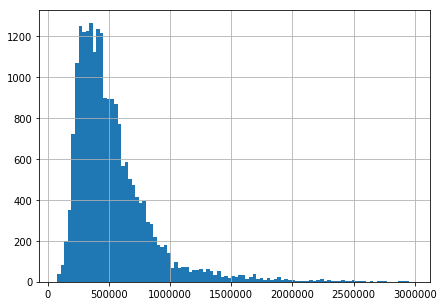

In [25]:
df_raw['price'].hist(bins=100, figsize=(7,5))

That looks better! Later on we can log-transform this column and use min-max scaling to tuck in the outliers and give its histogram more of a Gaussian shape.

## Scrubbing: filling in null values for waterfront

How many null values?

In [26]:
#Every null value is returned as False; add up the Falses for total of nulls
print(df_raw['waterfront'].isna().sum(), 'null values in waterfront column') 

2375 null values in waterfront column


It's safe to assume these 2376 houses do not front the water. Let's fill them with 0. Later they'll be converted to a categorical value.

In [20]:
df_raw['waterfront'] = df_raw['waterfront'].fillna(0) #Fill null values with 0, i.e. "Is waterfront = False"

## Scrubbing: filling in null values for view

How many null values are there, and which other value is the most reasonable to fill them with?

In [28]:
print(df_raw['view'].value_counts()) #Returns the sum of the observations of each value in the column
print('\n')
print('Total nulls in view: ', df_raw['view'].isna().sum())

0.00    19403
2.00      953
3.00      506
1.00      328
4.00      290
Name: view, dtype: int64


Total nulls in view:  62


Most houses have a "0" view. That's a pity. We can assume the 62 nulls also have a "0" view.

In [21]:
df_raw['view'] = df_raw['view'].fillna(0)

## Scrubbing: filling in null values for yr_renovated

How many rows have a yr_renovated value that isn't 0 or null?

In [22]:
yr_rn_total = df_raw.shape[0] #Total number of rows in yr_renovated
yr_rn_zeros = df_raw[df_raw['yr_renovated'] == 0.00].shape[0] #Number of 0 values in yr_renovated
yr_rn_nulls = df_raw['yr_renovated'].isna().sum() #Number of nulls in yr_renovated

print('Rows in yr_renovated:', yr_rn_total)
print('Zero values:', yr_rn_zeros)
print('Null values:', yr_rn_nulls)
print('Non-zero, non-null values:', (yr_rn_total - yr_rn_zeros - yr_rn_nulls))
print('Non-zero/non-null as percent of all values:', 
      round((((yr_rn_total - yr_rn_zeros - yr_rn_nulls) * 100) / yr_rn_total), 2),
      '%')

Rows in yr_renovated: 21542
Zero values: 16972
Null values: 3835
Non-zero, non-null values: 735
Non-zero/non-null as percent of all values: 3.41 %


Not enough values for the column to be useful. Let's drop it.

In [23]:
#Save yr_renovated for later, just in case
yr_renovated = df_raw['yr_renovated']

In [24]:
df_raw = df_raw.drop(['yr_renovated'], axis=1) #Drop the yr_renovated column

## Scrubbing: convering sqft_basement values to integers

In [33]:
df_raw['sqft_basement'].head(7)

0       0.0
1     400.0
2       0.0
3     910.0
4       0.0
5    1530.0
6         ?
Name: sqft_basement, dtype: object

In [34]:
type(df_raw['sqft_basement'][1]) #Looks like the float 400.0 but is actually the str'400.0'

str

This column is riddled with '?'s and values that look numerical but are actually strings. Let's replace '?' with 0, and convert the fake number strings into floats, and then into integers.

In [25]:
df_raw['sqft_basement'] = df_raw['sqft_basement'].replace('?', 0)
df_raw['sqft_basement'] = df_raw['sqft_basement'].astype('float') #Must convert strings to floats first
df_raw['sqft_basement'] = df_raw['sqft_basement'].astype('int') #Then convert the floats to integers

# Exploring

Now that the data is scrubbed we can begin to look at relationships among the features. We might be able to drop more columns and eliminate some outlier rows.

## Exploring: multicollinearity

Let's use a heatmap to check if any features follow the same curve as any others. Collinearity could reduce the accuracy of our model later on.

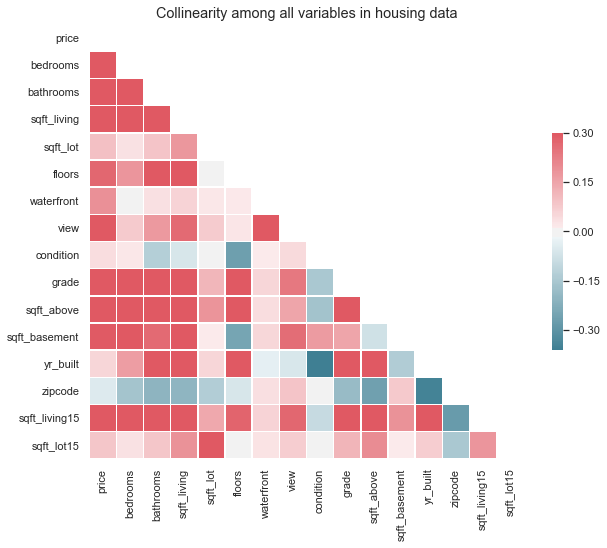

In [26]:
draw_heat_map(df_raw, 'Collinearity among all variables in housing data')

Yikes. There is a lot of collinearity across columns. But we probably don't need so many ways of measuring the area of the house. 

There are 6 different measures of square footage. Let's pick 1 or 2.

## Exploring: measures of area of a house

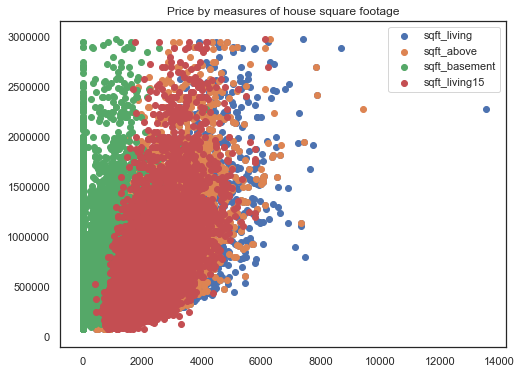

In [27]:
#Plot the first 4 measures of sqft on top of each other to compare
plt.figure(figsize=(8, 6))
plt.scatter(df_raw['sqft_living'], df_raw['price'], label='sqft_living')
plt.scatter(df_raw['sqft_above'], df_raw['price'], label='sqft_above')
plt.scatter(df_raw['sqft_basement'], df_raw['price'], label='sqft_basement')
plt.scatter(df_raw['sqft_living15'], df_raw['price'], label='sqft_living15')
plt.title('Price by measures of house square footage')
plt.legend()

A lot of overlap among all 4. Let's keep sqft_living and drop the rest. While we're at it, let's drop the 14,000sq ft house from sqft_living since it's so much bigger than the next biggest.

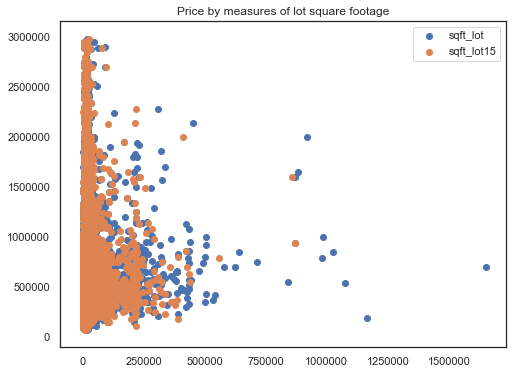

In [28]:
#Plot the other 2 measures of sqft to compare
plt.figure(figsize=(8, 6))
plt.scatter(df_raw['sqft_lot'], df_raw['price'], label='sqft_lot')
plt.scatter(df_raw['sqft_lot15'], df_raw['price'], label='sqft_lot15')
plt.title('Price by measures of lot square footage')
plt.legend()

Neither of these looks very helpful. Not only do they overlap each other quite closely, but the upward thrust close to x=0 suggests that smaller lots are priced across the full range of price values. In other words, you can probably maximize the value of your house even if your lot is small.

## Scrubbing: dropping extra area columns

In [29]:
#Drop multicollinear columns
df_raw = df_raw.drop(['sqft_above', 'sqft_basement', 'sqft_living15', 
                      'sqft_lot', 'sqft_lot15'], axis=1) 
df_raw = df_raw.rename(index=str, columns={'sqft_living': 'sqft'})

In [30]:
df_raw = df_raw.reset_index(drop=True) #Prevents dropped rows from throwing errors later

Let's knock out that extreme outlier from sqft_living, too.

In [31]:
df_raw[df_raw['sqft'] >= 13000] #Find the extreme outlier in sqft

,price,bedrooms,bathrooms,sqft,floors,waterfront,view,condition,grade,yr_built,zipcode
12733,2280000.00,7,8.00,13540,3.00,0.00,4.00,3,12,1999,98053


In [32]:
df_raw = df_raw.drop([12733]) #Drop the one extreme outlier from sqft

In [33]:
df_raw = df_raw.reset_index(drop=True) #Prevents dropped rows from throwing errors later

## Scrubbing: feature scaling of continuous variables

In [34]:
df_normed = df_raw.copy() # A deep copy of the raw data to normalize

In [35]:
#First log-transform each column to reduce skew
#and set a similar scale for each
price_normed = np.log(df_normed['price'])
sqft_normed = np.log(df_normed['sqft']) 
yr_built_normed = np.log(df_normed['yr_built'])

In [36]:
#Use min-max scaling to reduce effect of outliers
price_normed = (price_normed - min(price_normed)) / (max(price_normed) - min(price_normed))

#Standardize to take z-scores
sqft_normed = (sqft_normed - sqft_normed.mean()) / sqft_normed.std()
yr_built_normed = (yr_built_normed - yr_built_normed.mean()) / yr_built_normed.std()

In [37]:
#Replace the columns with the normalized data
df_normed['price'] = price_normed
df_normed['sqft'] = sqft_normed
df_normed['yr_built'] = yr_built_normed

# Exploring: looking at relationships

Let's check some of the feature relationships again before converting the categorical variables.

## Exploring: sqft and price

C:\Users\Stee\Anaconda3good\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


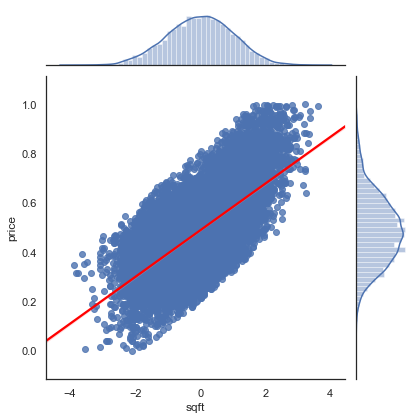

In [38]:
sns.jointplot(x='sqft', y='price', data=df_normed, kind='reg', 
                  label='sqft', joint_kws={'line_kws':{'color':'red'}})

With sqft and price both normalized, it's clear that there's an almost perfect positive linear relationship between the two.

All other things being equal, the size of your house should predict its price. Of course in real life all the other things are not equal. A more practical model will predict price using our other features too.

## Exploring: grade and price

C:\Users\Stee\Anaconda3good\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


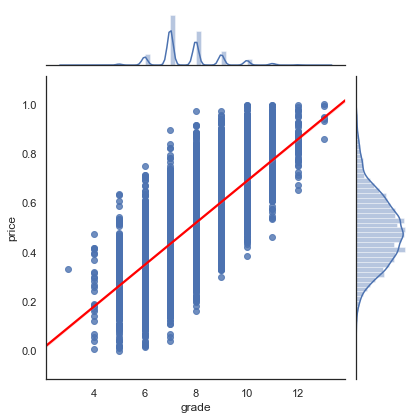

In [39]:
sns.jointplot(x='grade', y='price', data=df_normed, kind='reg', 
                  label='grade', joint_kws={'line_kws':{'color':'red'}})

But grade also has a very clear positive linear relationship with price! Maybe grade and sqft are too correlated?

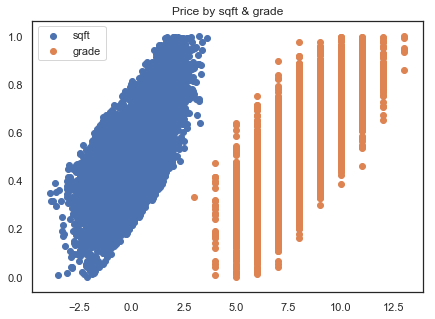

In [40]:
plt.figure(figsize=(7, 5))
plt.scatter(df_normed['sqft'], df_normed['price'], label='sqft')
plt.scatter(df_normed['grade'], df_normed['price'], label='grade')
plt.title('Price by sqft & grade')
plt.legend()

They're so similar that we might as well drop the grade column.

In [41]:
df_normed = df_normed.drop(['grade'], axis=1)

Do any of the other categorical variables have such a strong relationship with price?

## Exploring: view and price

### Question: is it possible to maximize the value of your home without having a spectacular view?

C:\Users\Stee\Anaconda3good\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


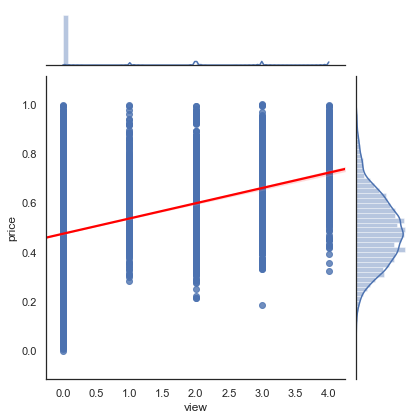

In [42]:
sns.jointplot(x='view', y='price', data=df_normed, kind='reg', 
                  label='view', joint_kws={'line_kws':{'color':'red'}})

Evidence for a positive linear relationship between view and price, but not very strong. Worth leaving the view columns in.

The 0 column has values at the full range of prices, including many at the maximum price value.

### Answer: a high-value home doesn't need a great view.

## Exploring: condition and price

C:\Users\Stee\Anaconda3good\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


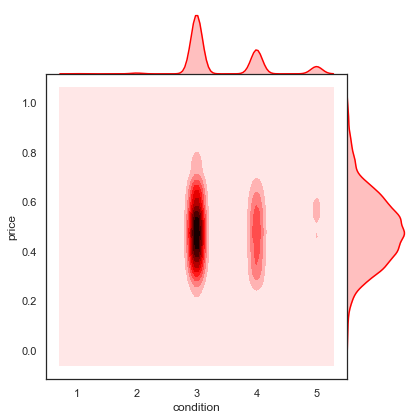

In [43]:
sns.jointplot(x='condition', y='price', data=df_normed, kind="kde", space=0, color="red")

High density around a "medium" condition. No evidence for a strong relationship between price and poor condition.

## Exploring: another check for collinearity

Now that we have fewer variables, let's check if we still have high multicollinearity.


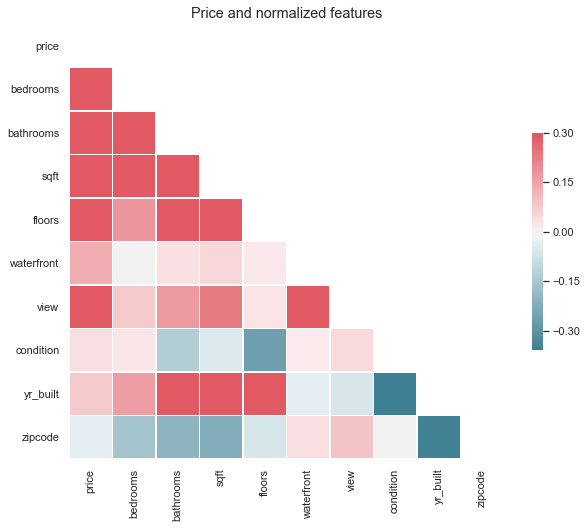

In [44]:
draw_heat_map(df_normed, 'Price and normalized features')

Still some collinearity among our remaining measures of area.

### Question: can square footage serve as a proxy for the number of bedrooms, bathrooms, and floors?

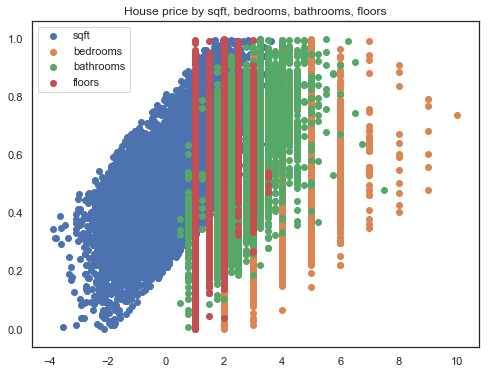

In [45]:
plt.figure(figsize=(8,6))
plt.scatter(df_normed['sqft'], df_normed['price'], label='sqft')
plt.scatter(df_normed['bedrooms'], df_normed['price'], label='bedrooms')
plt.scatter(df_normed['bathrooms'], df_normed['price'], label='bathrooms')
plt.scatter(df_normed['floors'], df_normed['price'], label='floors')
plt.title('House price by sqft, bedrooms, bathrooms, floors')
plt.legend()
plt.show()

Sqft has the clearest linear relationship with the normalized price column. Floors will just add 'noise' to the data. Bedrooms and bathrooms follow a similar-enough trajectory to sqft that we can use sqft as a proxy for them.

### Answer: Square footage can predict the price of a home without the need to count the number of bedrooms, bathrooms, or floors.

In [46]:
#Drop the extra area columns
df_normed = df_normed.drop(['bedrooms', 'bathrooms', 'floors'], axis=1)

Now that we've reduced collinearity by dropping some variables, we're ready to transform our categorical variables.

## Scrubbing: converting categorical variables

In [47]:
df_cat = df_normed.copy() #Normalized data, ready for categorizing

In [48]:
#Convert data to dtype 'category'
df_cat['waterfront'] = df_cat['waterfront'].astype('bool').astype('category')
df_cat['view'] = df_cat['view'].astype('int').astype('category')
df_cat['condition'] = df_cat['condition'].astype('int').astype('category')
df_cat['zipcode'] = df_cat['zipcode'].astype('category')

In [49]:
#Create a new set of columns for each category
water_dummies = pd.get_dummies(df_cat['waterfront'], prefix='water')
view_dummies = pd.get_dummies(df_cat['view'], prefix='view')
condit_dummies = pd.get_dummies(df_cat['condition'], prefix='condit')
zip_dummies = pd.get_dummies(df_cat['zipcode'], prefix='zip')

In [50]:
#Drop original columns
df_cat = df_cat.drop(['waterfront', 'view', 'condition', 'zipcode'], axis=1)
#Add the new columns
df_cat = pd.concat([df_cat, water_dummies, view_dummies, condit_dummies, zip_dummies], axis=1)

In [51]:
print(f"df_cat now has {df_cat.shape[1]} columns")

df_cat now has 85 columns


Now let's drop the last column of each category. (Values not contained in any other column in the set of dummies will by default by contained in the last column, so we can assume they are there and drop it.)

In [52]:
df_cat = df_cat.drop(['water_True', 'view_4', 
                      'condit_5', 'zip_98199'], axis=1)
print(f"df_cat now has {df_cat.shape[1]} columns")

df_cat now has 81 columns


# Modeling: the first model

In [53]:
df = df_cat.copy() #Final version of data, ready for modeling

Our first model uses three normalized continuous variables and four sets of categorical variables.

In [54]:
calc_MSEs(df, 'price', 0.25)

MSE for training data: 0.0031981635954105854
MSE for testing data: 0.0032066642427653735
Intercept: 0.8400653971089962
R-squared score: 0.8412318428827434


The first model shows very low errors and a very high R-squared score, indicating the model fits the data very well. It may be over-fitted. I suspect that sqft is so perfectly correlated to price that it conceals the relationship between price and the other factors. 

## Modeling: iterative feature selection for the first model

Let's get R-squared scores by adding features to the model iteratively.

In [57]:
#Create a df to track the frequency of selection for each feature in the data
# and the R-squared score of the model as each feature is added
df_iter_rsqds = r_squared_as_features_increase(df, 'price')

In [58]:
df_iter_rsqds.head()

,feature,count,r-squared
0,yr_built,1.00,0.01
1,zip_98107,2.00,0.03
2,zip_98033,3.00,0.08
3,zip_98005,4.00,0.11
4,zip_98122,5.00,0.14


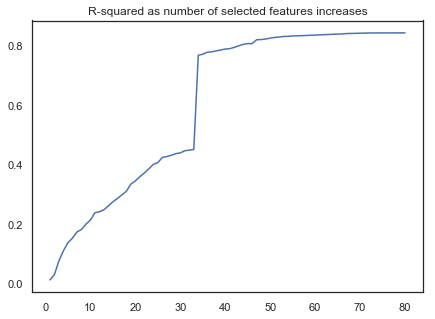

In [59]:
plot_iter_rsqds(df_iter_rsqds)

R-squared approaches 1.0 as number of selected fatures increases. (The closer the score to 1, the more we can attribute the change in the target to the changes in the features.) It makes a dramatic jump when the ~34th feature is added. Which feature is this?

In [60]:
df_iter_rsqds.iloc[30:36]

,feature,count,r-squared
30,zip_98034,31.00,0.45
31,zip_98126,32.00,0.45
32,zip_98024,33.00,0.45
33,view_0,34.00,0.77
34,condit_1,35.00,0.77
35,zip_98011,36.00,0.78


The r-squared score of the model jumps from .45 to 0.77 when view_0 is added. My guess that the jump happened because of sqft turns out to be wrong. Why is view_0 such an important feature?

In [61]:
print(df['view_0'].sum(), 'out of', df.shape[0], 'houses have a 0 view.')

19465 out of 21541 houses have a 0 view.


This feature adds a datapoint to the majority of the houses in the data set. The minority of houses remaining either have a 1 view or a de facto 2 view from the view column dropped earlier.

Looking at the graph again, it appears that after about the ~45th feature, the rate of increase in the R-squared score tapers off. The remaining features do not significanlty increase the score. Which features are these?

In [63]:
df_iter_rsqds.iloc[34:58]

,feature,count,r-squared
34,condit_1,35.00,0.77
35,zip_98011,36.00,0.78
36,zip_98133,37.00,0.78
37,zip_98118,38.00,0.78
38,zip_98155,39.00,0.78
39,zip_98070,40.00,0.79
40,zip_98028,41.00,0.79
41,zip_98065,42.00,0.79
42,zip_98045,43.00,0.80
43,zip_98014,44.00,0.80


After the 50th feature, zip_98102, the rate of increase in the R-squared score slows. Beyond this point the features seem to have a lower impact on the R-squared scores. Let's save them for later as the "low impact" features.

In [67]:
#Save a list of the 'low-impact' features to work with later
low_impact_features = list(df_iter_rsqds['feature'][df_iter_rsqds['count'] > 50])

## Modeling: iteratively generating test/train errors to find optimal split

Sqft apparently does not have an outsized influence on the R-squared score, so perhaps the model just has too many features? Let's check R-squared scores on different proportions of training and testing data as another way of looking for overfitting.

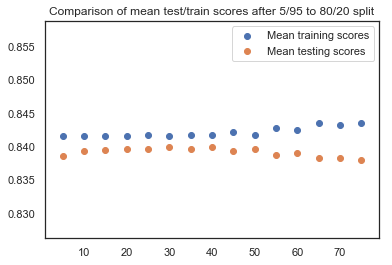

In [70]:
#Iterates over a range of train/test splits. Fits a model for each split many times,
#then takes the mean of them all. Plots the mean value for each split.
#Ideally, the training and testing sets should form mirror parabolic curves 
#as the data gets overfitted.
plot_tt_splits(df.drop(['price'], axis=1), df['price'])

# Interpreting: the first model

Because the data is normalized, the errors (represented by R-squared scores here) will never be too high. But we  can see that the scores of the training and testing data begin to move away from each other between the 40/60 split and the 50/50 split, showing that after this point, the training data begins to be overfitted.

Let's see if some of the categorical variables are just adding 'noise' and can be dropped. Then we can compare them to the low-impact columns from the R-squared analysis earlier.

It's possible that some of the variables in each category are adding noise, and it's also possible that an entire category of variables may be adding noise and needs to be dropped.

# Exploring categorical variables

In [71]:
df2 = df.copy()

Let's work with each set of categorical variables by comparing them to price and to each other.

In [72]:
#An index of column names for each categorical feature: water, view, condit, zipcode
water = df2.columns[df2.columns.str.contains(pat = 'water')]
view = df2.columns[df2.columns.str.contains(pat = 'view')]
condit = df2.columns[df2.columns.str.contains(pat = 'condit')]
zipcode = df2.columns[df2.columns.str.contains(pat = 'zip')]

In [73]:
#An ordinary least squares model for each categorical set of columns compared to price
water_model = build_ols_model(water, df2['price'], df2, 'price')
view_model = build_ols_model(view, df2['price'], df2, 'price')
condit_model = build_ols_model(condit, df2['price'], df2, 'price')
zipcode_model = build_ols_model(zipcode, df2['price'], df2, 'price')

In [74]:
cat_models = [water_model, view_model, condit_model, zipcode_model]
cats = ['water', 'view', 'condit', 'zip']

In [75]:
for i in range(len(cat_models)):
    print(cats[i], ':', cat_models[i].rsquared)

water : 0.018337693253682508
view : 0.11154867136804325
condit : 0.013885397819908163
zip : 0.5304820263795713


View's R-squared value is more significant than that of water and condition. We know that most houses have a '0' water value, and from our earlier joint plot we know that condition has density around the middle values of price. Zip code is the only set of categorical variables that has a relatively high R-squared score in its model with price.

Let's examine view and zip code further and see if we can drop some of their variables to tighten up our model.

In [76]:
price_and_view = pd.concat([df2['price'], df2[view]], axis=1)
price_and_zipcode = pd.concat([df2['price'], df2[zipcode]], axis=1)

## Exploring categorical variables: view

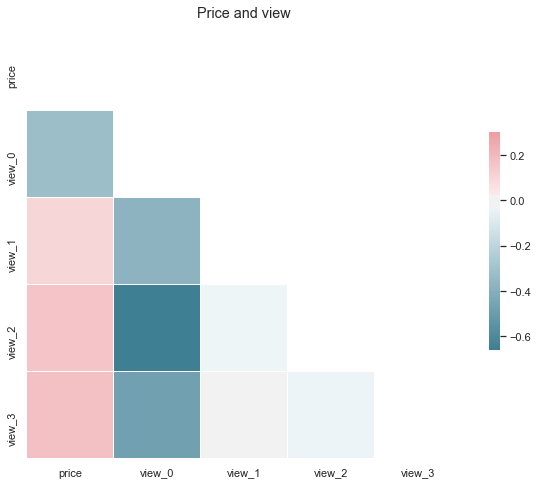

In [77]:
draw_heat_map(price_and_view, 'Price and view')

Interesting sign of a downward relationship between price and view_0 and positve relationship between price and the other views. Might be more economical to concatonate views 1, 2, and 3 into a single column to contrast with view_0. This should reduce 'noise' in the final model.

In [78]:
#Add together the values of the view 1, 2, and 3 columns
arr_views123 = np.array(df2['view_1']) + np.array(df2['view_2']) + np.array(df2['view_3'])
#Convert the new array back into a pandas Series
df_views123 = pd.Series(arr_views123)
#Rename the Series as view_1
df_views123 = df_views123.rename('view_1')
#Drop the old view columns
df2 = df2.drop(['view_1', 'view_2', 'view_3'], axis=1)
#Add the new view column to the df
df2 = pd.concat([df2, df_views123], axis=1)

## Exploring categorical variables: zip codes

### Question: In pursuit of "location, location, location," is zip code a useful predictor of the price of a home, indicating a good or bad location?

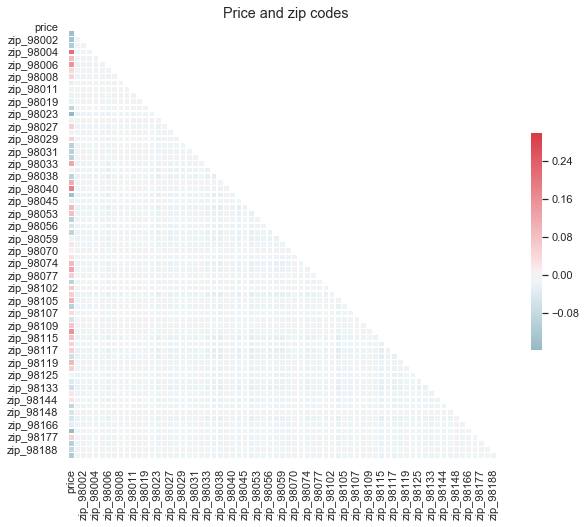

In [79]:
draw_heat_map(price_and_zipcode, 'Price and zip codes')

Of course, there cannot be any collinearity among zip codes because no 2 zip codes' 'True' values share a row.

Looks like some zip codes have a strong positive or negative relationship with price while many don't. Might be useful to see them arranged in descending order by the mean house price of each zip code. Then the zip codes with the weakest relationship to price can be dropped.

In [80]:
mean_prices_of_zips = []
for column in zipcode:
    #Add the mean of the prices for all observations in each zip code column
    #where the particular zip code value is 1 (or True)
    mean_prices_of_zips.append(df2['price'][df2[column] == True].mean())
#A new dictionary to combine zipcodes with their mean prices
d = {'zipcode': zipcode, 'mean_price': mean_prices_of_zips}
#A new dataframe from the dictionary
mean_prices_zips = pd.DataFrame(data=d)
#Correct the dataframe for mean prices
mean_prices_zips['mean_price'] = mean_prices_zips['mean_price'].astype('float')
#Order zip codes by mean house price, highest first
mean_prices_zips = mean_prices_zips.sort_values(by=['mean_price'], ascending=False)

Perhaps we can 'bin' together certain zip codes by physical proximity if they seem to contain similar kinds of houses? This would reduce collinearity.

In [81]:
#Top 10 mean house prices by zip code
mean_prices_zips[0:10]

,zipcode,mean_price
24,zip_98039,0.84
3,zip_98004,0.74
25,zip_98040,0.72
48,zip_98112,0.69
47,zip_98109,0.63
4,zip_98005,0.63
5,zip_98006,0.63
43,zip_98105,0.63
53,zip_98119,0.63
41,zip_98102,0.62


(The price column has been transformed so the max price is now 1.00.This is about 3 million dollars.)

    98039 Medina
    98004 Bellevue
    98040 Mercer Island
    98112 Madison Park and Montlake in Seattle
    98109 Eastern half of Queene Anne and South Lake Union
    98005 Bellevue
    98006 South Bellevue
    98105 U District
    98119 Queene Anne
    98102 East Lake and north Broadway corridor of Capitol Hill

It's worth noting that the top 10 zip codes by mean house price are scattered around the county. It would make little sense to 'bin' them together, or indeed to bin together zip codes in any arrangement. Any two zip codes whose numbers are close together aren't necessarily geographic neighbors, and may not contain similar kinds of houses.

Let's look at all the zip code columns arranged by mean house price.

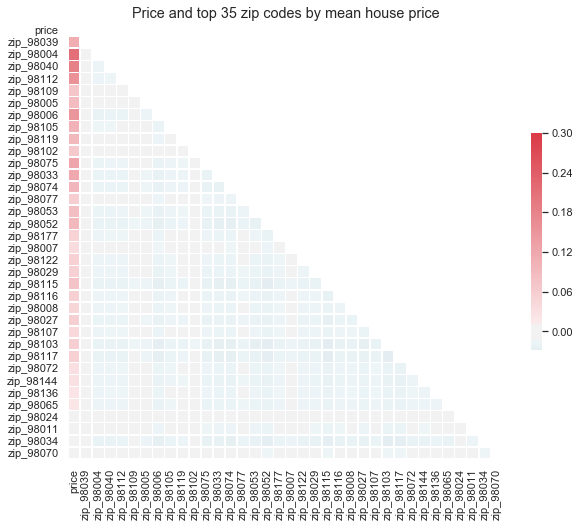

In [82]:
#Draw a heat map of the top 35 zip codes by mean house price
top_0_35_zips = pd.Index(
                mean_prices_zips[0:35]['zipcode'])
price_and_zip_0_35 = pd.concat([df2['price'], df2[top_0_35_zips]], axis=1)
draw_heat_map(price_and_zip_0_35, 'Price and top 35 zip codes by mean house price')

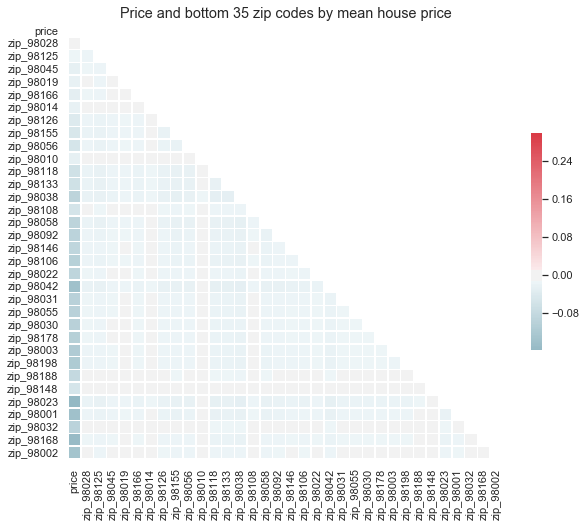

In [83]:
#Draw a heat map of the bottom 35 zip codes by mean house price
bot_36_70_zips = pd.Index(
                mean_prices_zips[36:70]['zipcode'])
price_and_zip70 = pd.concat([df2['price'], df2[bot_36_70_zips]], axis=1)
draw_heat_map(price_and_zip70, 'Price and bottom 35 zip codes by mean house price')

Strong positive relationship between price and the zip codes with the highest average house prices; strong negative relationship between price and the zip codes with the lowest average house prices. Suggests that the "middle" of the range is just noise which might be muddling the model and adding to computation time.

### Answer: Zip code is a useful price predictor at the high and low ends. High-value homes are clustered in 'good neighborhood' zip codes. Low-value homes are correspondingly clustered in 'bad neighborhood' zip codes.

Let's keep the top 20 and bottom 20 in place and pull out the middle 30 to compare to the "low_impact" zip codes from earlier.

In [84]:
#Create an index object with names of the 'middle 30' zipcodes by mean house price
middle_30_zips = pd.Index(
                mean_prices_zips[20:50]['zipcode'])

In [86]:
#Make a copy of low_impact_features and remove the non-zip code variables
low_impact_zips = copy.deepcopy(low_impact_features)
low_impact_zips.remove('water_False')

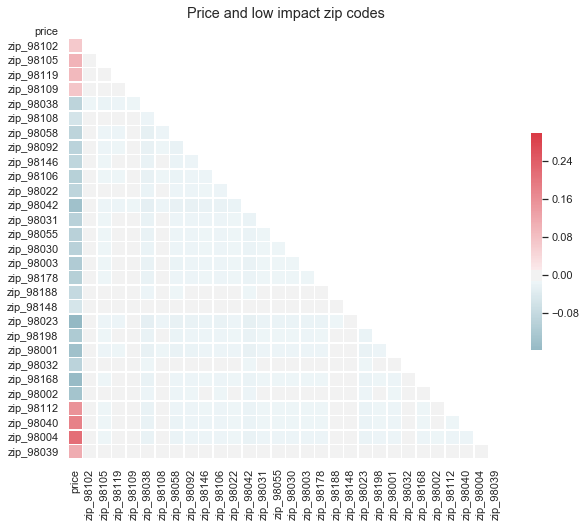

In [87]:
price_and_low_impact_zips = pd.concat([df2['price'], df[low_impact_zips]], axis=1)
draw_heat_map(price_and_low_impact_zips, 'Price and low impact zip codes')

I'm surprised to see that the low_impact_zips from the earlier analysis of R-squared scores all have a positive or negative relationship with price. I would have assumed that they had a negligible relationship. In fact I expected there to be a lot of overlap between this list and the middle_30 list, but there is very little.

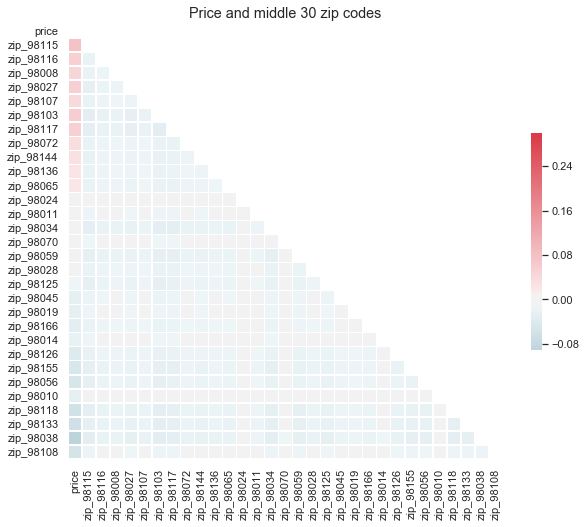

In [88]:
price_and_middle_30_zips = pd.concat([df2['price'], df[middle_30_zips]], axis=1)
draw_heat_map(price_and_middle_30_zips, 'Price and middle 30 zip codes')

The middle 30 zip codess have a weak relationship with price and very few of them overlap with the low-impact zip codes. Which set would be better to include in the final model?

In [89]:
#Build a model including the 'low impact' zip codes
df3 = df2.drop(middle_30_zips, axis=1)
df3_features = df3.drop(['price'], axis=1)
df3_features_index = df3_features.columns
df3_model = build_ols_model(df3_features_index, df3['price'], df3, 'price')

In [90]:
#Build a model including the 'middle 30' zip codes
df4 = df2.drop(low_impact_zips, axis=1)
df4_features = df4.drop(['price'], axis=1)
df4_features_index = df4_features.columns
df4_model = build_ols_model(df4_features_index, df4['price'], df4, 'price')

In [91]:
print_ols_stats(df3_model)

R-squared: 0.7763610877665773
R-squared adjusted: 0.7758616150424379
Intercept: 0.7204679918800865
Slope: 0.07630941026977028


In [92]:
df3_model.pvalues.max()

0.00015038018991154627

In [93]:
print_ols_stats(df4_model)

R-squared: 0.6277593427942878
R-squared adjusted: 0.6269106250890586
Intercept: 0.6548996153768432
Slope: 0.092440785267002


In [94]:
df4_model.pvalues.max()

0.932930256906673

The model using the 'low impact' zip codes had a higher R-squared score and produced no p-values close to 0.05. The model with the 'middle 30' zip codes had a lower R-squared score and had at least one variable with a very high p-value. (A high p-value indicates a high likelihood that there is not a relationship between the target and that particular feature.)

For our final model, therefore, we should include the 'low-impact' zip codes and drop the 'middle 30' zip codes.

Just as a sanity check, let's make sure that it's better to include some zip codes than to include none at all.

In [95]:
#Build a model without any zip code columns
df5 = df2.drop(zipcode, axis=1)
df5_features = df5.drop(['price'], axis=1)
df5_features_index = df5_features.columns
df5_model = build_ols_model(df5_features_index, df5['price'], df5, 'price')

In [96]:
print_ols_stats(df5_model)

R-squared: 0.5035837424360574
R-squared adjusted: 0.5033762394720485
Intercept: 0.6896868630751195
Slope: 0.0965820868602277


Right. This model is less accurate than either of our models that included some zip codes. Now we know which to leave in and which to leave out.



# Modeling: the final model

Let's check R-squared scores for different sizes of training and testing data to determine what testing size to use.

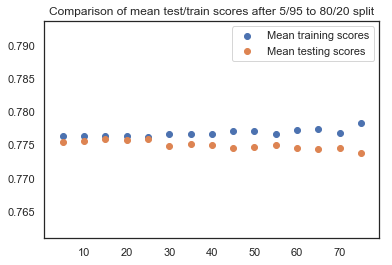

In [97]:
#Iteratively run the model with a range of train test splits
plot_tt_splits(df3.drop(['price'], axis=1), df3['price'])

We first see errors minimized when the train/test split is at about 25/75. Let's proceed with this split to see how well new data fits the model by calculating its mean squared errors.

In [98]:
#Call the calc_MSEs function to calculate mean squared errors using a sklearn 
#Linear Regression object and the sklearn mean_squared_error function.
calc_MSEs(df3, 'price', 0.25)

MSE for training data: 0.0045174427815704915
MSE for testing data: 0.0044909745902737665
Intercept: 0.719741695386735
R-squared score: 0.7762154197319882


# Interpreting: the final model

These mean squared errors for the training and testing set are very low, and the intercept and R-squared score calculated here by sklearn match those calculated by statsmodels with OLS earlier.

Our final model can predict the value of a home up to 3 million dollars. It uses square footage as a proxy for all measures of the area of a home and of its lot; on its own, square footage is a strong predictor of price, but its effect is tempered by other useful measures. It turns out, for example, that certain zip codes contain clusters of very high- or low-valued homes. The neighborhood a home is in will affect its price. Even though a home's location matters, it need not have a great view of the rest of the neighborhood or of the mountains and lakes in King County. Many high-valued homes have no view at all.